In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as colors
from loadmodules import *
from scipy import stats

In [2]:
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl4' in directory]
print(simulation_list)

['Au6_lvl4_aa96_cfefit', 'Au6_lvl4_aa96_cfefit_noconstrain', 'Au6_lvl4_aa96_fixcs', 'Au6_lvl4_aa96_tightconstrain']


# ICMF sampling test

In [4]:
# sf = load_subfind(127, dir=path+simulation_list[0]+'/output/')
# s_clusterpdir = gadget_readsnap(127, snappath=path+simulation_list[0]+'/output/', subfind=sf, loadonlytype=[4], loadonlyhalo=0, applytransformationfacs=True)
# s_clusterpdir.calc_sf_indizes(sf)
# rot_matrix = s_clusterpdir.select_halo(sf)

sf = load_subfind(127, dir=path+simulation_list[3]+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(127, snappath=path+simulation_list[3]+'/output/', subfind=sf, hdf5=True, loadonlytype=4, loadonlyhalo=0)
s.calc_sf_indizes( sf )
galrad = 0.1 * sf.data['frc2'][0]
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

/storage/home/can35/can35007/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


array([[-0.13369912,  0.30828502,  0.94185184],
       [ 0.80876937, -0.51530016,  0.28347461],
       [ 0.57272738,  0.79964123, -0.18043631]])

In [5]:
solar_mass_g = 1.989e33
Gcosmo = 43.

In [6]:
starparts = s.data['type']==4
mclus = s.data['imcl'][s.data['incl']>0].flatten()*s.UnitMass_in_g/solar_mass_g
mtotclus = s.data['imfc'][s.data['incl']>0]*s.data['mass'][starparts][s.data['incl']>0]*s.UnitMass_in_g/solar_mass_g
nclus = s.data['incl'][s.data['incl']>0].flatten()
mtrunc = s.data['mtrc'][s.data['incl']>0] * s.UnitMass_in_g/solar_mass_g

In [7]:
stars_age = s.cosmology_get_lookback_time_from_a(s.data['age'], is_flat=True)

/storage/home/can35/can35007/pylib/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


In [9]:
def ICMF(norm, m, mtrunc):
    return norm*np.exp(-m/mtrunc)/m**2

def trapz_log(norm, min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(norm, current, mtrunc) + IMF(norm, next, mtrunc))
    return integral

In [11]:
nbins = 25
min_gcmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(np.log10(marray_gcmf))

N,_ = np.histogram(mclus[mclus>0], bins=marray_gcmf, density=True)
initial_population = N/width

In [12]:
norm = 1/trapz_log(1., min_gcmf, max_gcmf, mtrunc, ICMF, 500)

In [13]:
ICMF_array=[]

for i in range(len(mtrunc)):
    ICMF_array.append(ICMF(norm[i], marray_gcmf, mtrunc[i]))

ICMF_array = np.array(ICMF_array)

In [14]:
%matplotlib inline

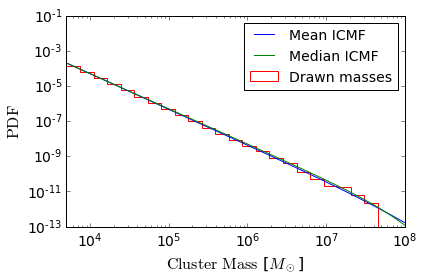

In [15]:
plt.loglog(marray_gcmf, np.mean(ICMF_array,axis=0), label='Mean ICMF')
plt.loglog(marray_gcmf, np.median(ICMF_array,axis=0), label='Median ICMF')
# plt.hist(mtotclus/nclus, bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
plt.hist(mclus[mclus>0], bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
# plt.step(marray_gcmf[:-1], initial_population, where='post', label='Initial Population')
plt.legend(fontsize=14)
plt.ylim(1e-13, 1e-1)
plt.xlim(min_gcmf, max_gcmf)
plt.xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.yticks(np.logspace(-13, -1, 7))
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tight_layout()
# plt.savefig('plots/icmf_sampling_test.pdf')

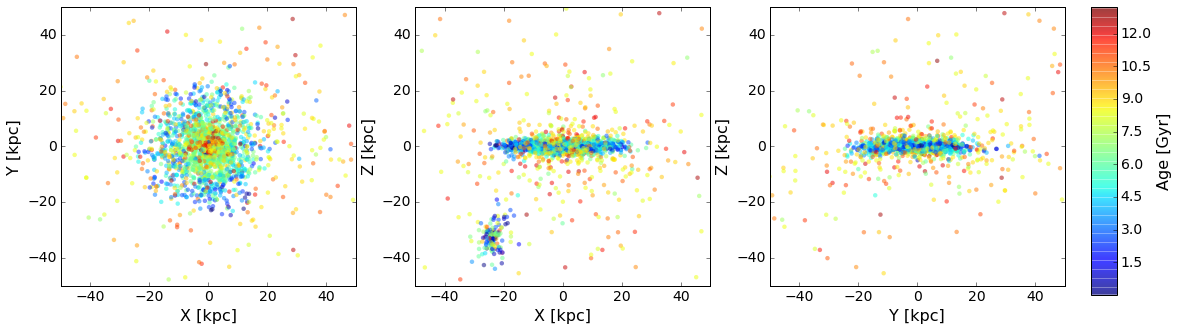

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,50)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[2].set_xlim(-50,50)
ax[2].set_ylim(-50,50)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

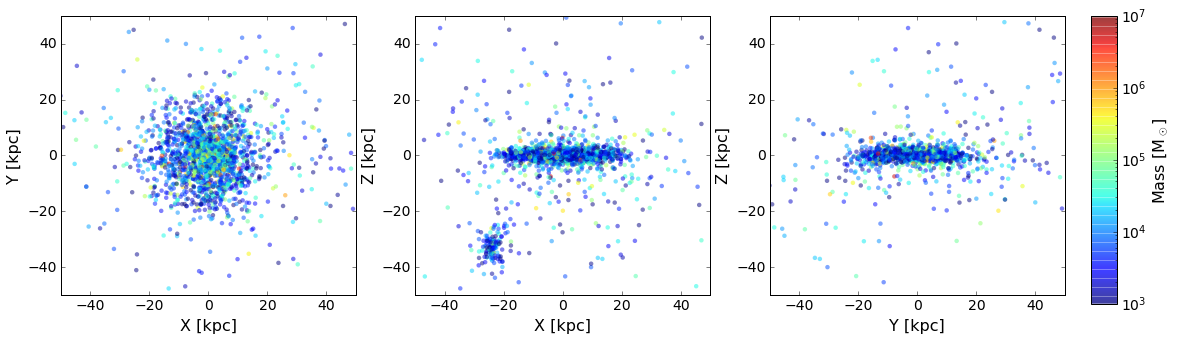

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=colors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=colors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,50)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=colors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[2].set_xlim(-50,50)
ax[2].set_ylim(-50,50)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Mass [M$_\odot$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

In [18]:
kinetic_energy = np.sum(s.data['vel']**2, axis=1)
# print(kinetic_energy)

orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
orbital_energy /= 1e5
# print(orbital_energy.min(),orbital_energy.max())
orbital_energy -= orbital_energy.max()
# print(orbital_energy.min(),orbital_energy.max())
Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
Lz *= np.sign(np.nanmedian(Lz))

star_radius = s.r()
isort_stars = np.argsort(star_radius)
revert_sort = np.argsort(isort_stars)
cummass = np.cumsum(s.data['mass'][isort_stars])
Vc_stars = np.sqrt(Gcosmo*cummass[revert_sort]/star_radius)

Lzmax = star_radius*Vc_stars

[  398.2699    722.2511    205.37985 ... 57959.504     101.39398
 25332.24   ]
-1.6000283 2.1642697
-3.764298 0.0


/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


In [20]:
circ_param = (Lz/Lzmax)

(array([0.00182548, 0.00182548, 0.00182548, 0.00365097, 0.00365097,
        0.02190581, 0.01642935, 0.04381161, 0.09492516, 0.2920774 ,
        0.39430449, 0.42533771, 0.52573932, 0.81051479, 1.24132895,
        0.82876962, 0.21723257, 0.04928806, 0.01277839, 0.01277839]),
 array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
         0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 1 Patch objects>)

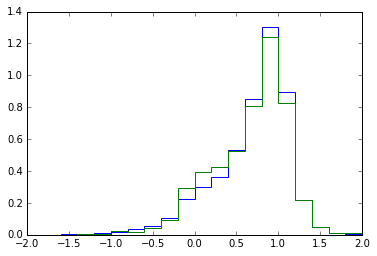

In [43]:
plt.hist(circ_param[starparts][s.data['age']>0], histtype='step', density=True, bins=20, range=[-2,2])
plt.hist(circ_param[starparts][s.data['nclt']>0], bins=20, range=[-2,2], histtype='step', density=True)

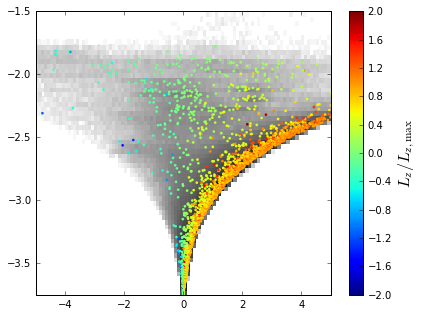

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
#index, = np.where((s.r() < 0.1) & (s.r() > 0.0))
ax.hist2d( Lz[starparts], orbital_energy[starparts], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][s.data['nclt']>0].min(), 0.]), rasterized=True, cmap='Greys', norm=colors.LogNorm() )
cb = ax.scatter( Lz[starparts][s.data['nclt']>0], orbital_energy[starparts][s.data['nclt']>0], c=circ_param[starparts][s.data['nclt']>0], vmin=-2, vmax=2, s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][s.data['nclt']>0].min(), -1.5)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label(r'$L_z / L_{z,\rm{max}}$', fontsize=16)

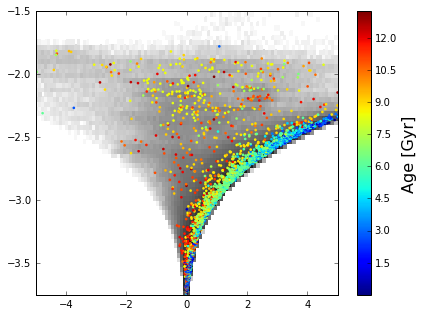

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.hist2d( Lz[starparts], orbital_energy[starparts], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][s.data['nclt']>0].min(), 0.]), rasterized=True, cmap='Greys', norm=colors.LogNorm() )
cb = ax.scatter( Lz[starparts][s.data['nclt']>0], orbital_energy[starparts][s.data['nclt']>0], c=stars_age[s.data['nclt']>0], s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][s.data['nclt']>0].min(), -1.5)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Age [Gyr]', fontsize=16)